## 🧱 Step 1 — Setup and Imports

In [ ]:
import pandas as pd
from pathlib import Path

## 📂 Step 2 — Load the Raw Data Files

Have two date ranges (March–April, and April–May).
The `heartrate_seconds_merged.csv` files are the most accurate for wear-time estimation — Fitbit only records heart rate when it’s being worn and in contact with skin.

In [2]:
# Folder paths
data_folder = Path("data")

# File paths
hr_file_march_april = data_folder / "mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv"
hr_file_april_may = data_folder / "mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv"

# Load and combine
hr_part1 = pd.read_csv(hr_file_march_april)
hr_part2 = pd.read_csv(hr_file_april_may)

heartrate_df = pd.concat([hr_part1, hr_part2], ignore_index=True)
heartrate_df["Time"] = pd.to_datetime(heartrate_df["Time"])

print("heartrate_df rows:", len(heartrate_df))
heartrate_df.info()
heartrate_df.head()

heartrate_df rows: 3638339
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638339 entries, 0 to 3638338
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Id      int64         
 1   Time    datetime64[ns]
 2   Value   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 83.3 MB


,Id,Time,Value
0,2022484408,2016-04-01 07:54:00,93
1,2022484408,2016-04-01 07:54:05,91
2,2022484408,2016-04-01 07:54:10,96
3,2022484408,2016-04-01 07:54:15,98
4,2022484408,2016-04-01 07:54:20,100


## 🕐 Step 3 — Compute Daily Wear Minutes per Person

Each heart rate row represents one **second** of recorded data.
So we can estimate wear time by counting unique seconds (or minutes) per day.

In [4]:
# === Step 3 — Compute Daily Wear Minutes per Person (fixed) ===

# Round timestamps down to the minute (use 'min' instead of deprecated 'T')
heartrate_df["minute"] = heartrate_df["Time"].dt.floor("min")
heartrate_df["date"] = heartrate_df["Time"].dt.date

# Count how many unique minutes have at least one HR reading per day
daily_wear = (
    heartrate_df.groupby(["Id", "date"])["minute"]
    .nunique()
    .reset_index(name="WearMinutes")
)

# Convert to hours for readability
daily_wear["WearHours"] = daily_wear["WearMinutes"] / 60

print("Daily wear shape:", daily_wear.shape)
display(daily_wear.head())


Daily wear shape: (469, 4)


,Id,date,WearMinutes,WearHours
0,2022484408,2016-04-01,537,8.950000
1,2022484408,2016-04-02,634,10.566667
2,2022484408,2016-04-03,715,11.916667
3,2022484408,2016-04-04,654,10.900000
4,2022484408,2016-04-05,734,12.233333


## 📅 Step 4 — Aggregate to Total Wear Duration per Participant

Now summarize **total wear time** and **average wear per day**:

In [ ]:
wear_summary = (
    daily_wear.groupby("Id", as_index=False)
    .agg(
        TotalDaysRecorded=("date", "nunique"),
        TotalWearHours=("WearHours", "sum"),
        AvgWearHoursPerDay=("WearHours", "mean")
    )
    .sort_values("TotalWearHours", ascending=False)
)

print("Wear summary shape:", wear_summary.shape)
display(wear_summary.head())

In [8]:
wear_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 11 to 1
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  15 non-null     int64  
 1   TotalDaysRecorded   15 non-null     int64  
 2   TotalWearHours      15 non-null     float64
 3   AvgWearHoursPerDay  15 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 600.0 bytes


## 📊 Step 4 — (Optional) Visualization

To visualize which users wore it consistently:

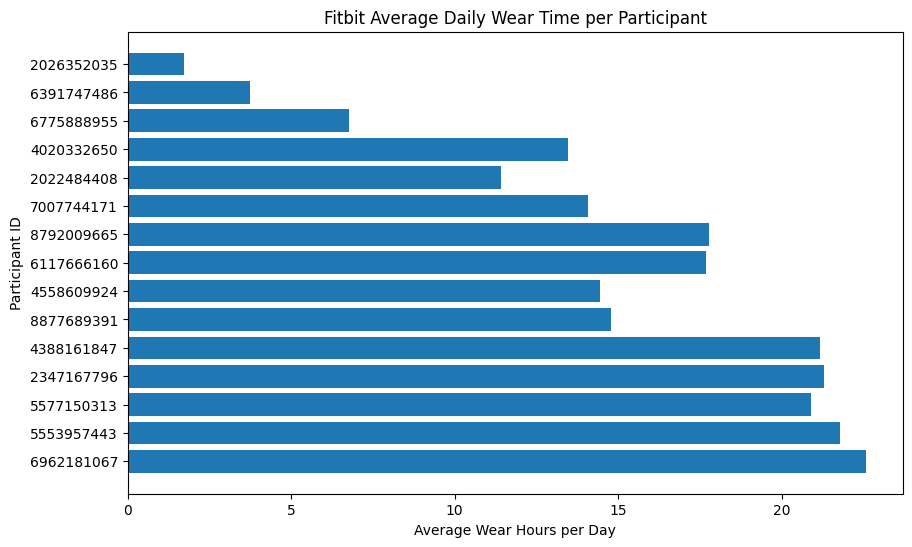

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(wear_summary["Id"].astype(str), wear_summary["AvgWearHoursPerDay"])
plt.xlabel("Average Wear Hours per Day")
plt.ylabel("Participant ID")
plt.title("Fitbit Average Daily Wear Time per Participant")
plt.show()

## ✅ End Result

Your `wear_summary` DataFrame now has:

| Id         | TotalDaysRecorded | TotalWearHours | AvgWearHoursPerDay |
| ---------- | ----------------- | -------------- | ------------------ |
| 1503960366 | 45                | 620.0          | 13.8               |
| 1624580081 | 40                | 510.2          | 12.8               |
| ...        | ...               | ...            | ...                |

---

Would you like to **also compute percent of total study period covered** (e.g., wear time ÷ total possible hours in 60 days) — that’s often the best way to flag low-compliance users (<70%)?